In [1]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from scipy.optimize import minimize

shape 342 548


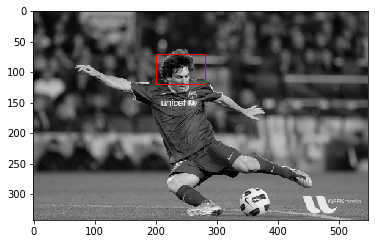

In [2]:
# import Messi
image = cv2.imread('./messi5.jpg')
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(img, cmap='gray');
rows, cols = img.shape
print('shape', rows, cols)

# and Define a box
x, y, w, h = 200, 70, 80, 50 #60, 70, 100, 50
box_polyline = np.array([[x, x+w, x+w, x, x],
                         [y, y, y+h, y+h, y]]).T
plt.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='box');

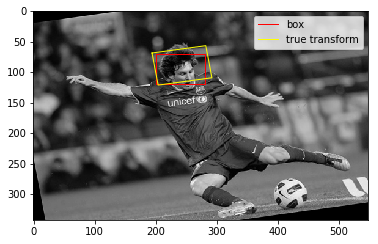

In [3]:
# Transform the image for testing
rows,cols = img.shape

M_test = np.array([[  1.1, 0.2, -40.],
                   [ -0.15, 1.05,  25.]])
 
img2 = cv2.warpAffine(img, M_test, (cols,rows),
                      flags=cv2.INTER_CUBIC)

# graph
plt.imshow(img2, cmap='gray');
plt.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='box');


xy1 = np.hstack([box_polyline, np.ones((box_polyline.shape[0], 1))])
box_tr = np.matmul(M_test, xy1.T).T
plt.plot(box_tr[:, 0], box_tr[:, 1],
         '-', color='yellow', linewidth=1, label='true transform');
plt.legend();

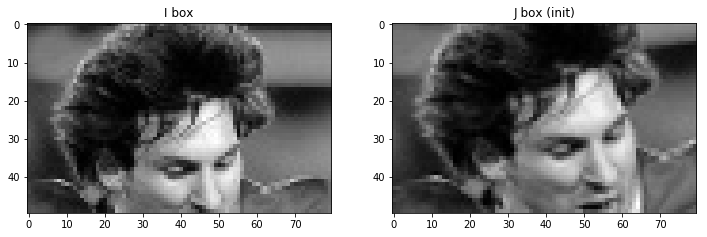

In [4]:
# Crop
# I box
M = np.array([[ 1., 0., -x],
              [ 0., 1., -y]])
 
I_box = cv2.warpAffine(img, M, (w, h),
                   flags=cv2.INTER_LANCZOS4)#INTER_LINEAR)#INTER_CUBIC)

# J box init
M = np.array([[ 1., 0., -x],
              [ 0., 1., -y]])
 
J_init = cv2.warpAffine(img2, M, (w, h),
                    flags=cv2.INTER_LANCZOS4)#INTER_CUBIC)

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.imshow(I_box, cmap = 'gray');
ax1.set_title('I box');
ax2.imshow(J_init, cmap = 'gray');
ax2.set_title('J box (init)');

In [5]:
# Comparison function
def normalize(I):
    return (I - I.mean())/I.std()

def znssd(I, J):
    """Zero-normalized sum of squared differences (ZNSSD)"""
    return np.sum( (normalize(I) - normalize(J))**2 )

# test
znssd(I_box, J_init)

4707.3309848882145

In [6]:
def opti_fun(M_flat, I, J_full):

    M = M_flat.reshape(2, 3)

    shape = I.T.shape
    J_transformed = cv2.warpAffine(J_full, M, shape,
                                   flags=cv2.INTER_LANCZOS4) #)INTER_LINEAR
    
    return znssd(I, J_transformed)

Optimization terminated successfully.
         Current function value: 1719.186395
         Iterations: 144
         Function evaluations: 296


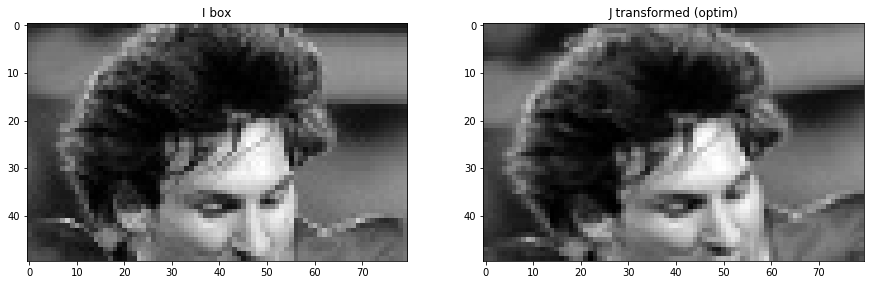

In [7]:
# Minimize
M_init = np.array([[ 1., 0., -x],
                   [ .0, 1., -y]]).flatten()
#M_init = cv2.invertAffineTransform(M_test) - np.array([[0, 0, x], [0, 0, y]])

res = minimize(opti_fun, M_init,
               args=(I_box, img2), options={'disp':True}, method='Nelder-Mead')

M_opt = res.x.reshape(2, 3)

# Solution
J_tr = cv2.warpAffine(img2, M_opt, (w, h),
                      flags=cv2.INTER_CUBIC) #INTER_CUBIC)

# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(normalize(I_box), cmap = 'gray');
ax1.set_title('I box');
ax2.imshow(normalize(J_tr), cmap = 'gray');
ax2.set_title('J transformed (optim)');

In [8]:
# Back transformation
translations = np.array([[ 0., 0., x],
                         [ 0., 0., y]])

M_sol = cv2.invertAffineTransform(M_opt + translations)
np.set_printoptions(precision=3, suppress=True)
print('M_sol:')
print(M_sol)

print('M_test:')
print(M_test)

M_sol:
[[  1.071  -0.002 -13.049]
 [ -0.      1.128 -19.195]]
M_test:
[[  1.1    0.2  -40.  ]
 [ -0.15   1.05  25.  ]]


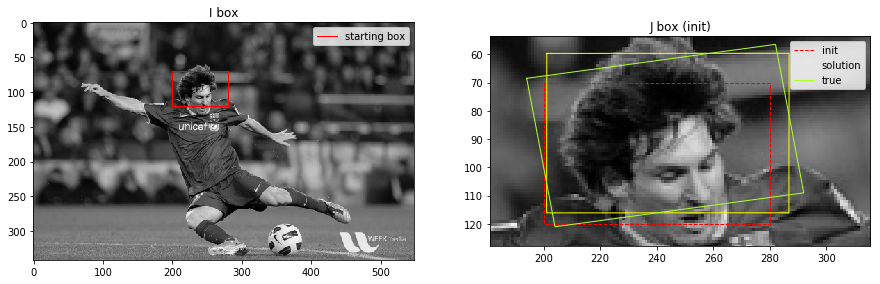

In [9]:
# Graph
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.imshow(normalize(img), cmap = 'gray');
ax1.set_title('I box');
ax2.imshow(normalize(img2), cmap = 'gray');
ax2.set_title('J box (init)');

# boxes
ax1.plot(box_polyline[:, 0], box_polyline[:, 1],
         '-', color='red', linewidth=1, label='starting box');
ax1.legend();


ax2.plot(box_polyline[:, 0], box_polyline[:, 1],
         '--', color='red', linewidth=1, label='init');

box_sol = np.matmul(M_sol, xy1.T).T #WAHAT
ax2.plot(box_sol[:, 0], box_sol[:, 1],
         '-', color='yellow', linewidth=1, label='solution');


box_true = np.matmul(M_test, xy1.T).T
ax2.plot(box_tr[:, 0], box_tr[:, 1],
         '-', color='greenyellow', linewidth=1, label='true');

ax2.legend();
# Zoom
ax2.set_xlim(box_sol[:, 0].min()*0.9, box_sol[:, 0].max()*1.1);
ax2.set_ylim(box_sol[:, 1].max()*1.1, box_sol[:, 1].min()*0.9);

### Next: image pyramid
https://docs.opencv.org/2.4/doc/tutorials/imgproc/pyramids/pyramids.html